In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import math
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
from typing import Optional, List

# %pip install gin
# import DeepTime.models.modules.inr.INR as INR

# set gpu as default device
torch.set_default_device("cuda")

In [2]:
class RidgeRegressor(nn.Module):
    def __init__(self, lambda_init: Optional[float] =0.):
        super().__init__()
        self._lambda = nn.Parameter(torch.as_tensor(lambda_init, dtype=torch.float))

    def forward(self, reprs: Tensor, x: Tensor, reg_coeff: Optional[float] = None) -> Tensor:
        if reg_coeff is None:
            reg_coeff = self.reg_coeff()
        w, b = self.get_weights(reprs, x, reg_coeff)
        return w, b

    def get_weights(self, X: Tensor, Y: Tensor, reg_coeff: float) -> Tensor:
        batch_size, n_samples, n_dim = X.shape
        ones = torch.ones(batch_size, n_samples, 1, device=X.device)
        X = torch.concat([X, ones], dim=-1)

        if n_samples >= n_dim:
            # standard
            A = torch.bmm(X.mT, X)
            A.diagonal(dim1=-2, dim2=-1).add_(reg_coeff)
            B = torch.bmm(X.mT, Y)
            weights = torch.linalg.solve(A, B)
        else:
            # Woodbury
            A = torch.bmm(X, X.mT)
            A.diagonal(dim1=-2, dim2=-1).add_(reg_coeff)
            weights = torch.bmm(X.mT, torch.linalg.solve(A, Y))

        return weights[:, :-1], weights[:, -1:]

    def reg_coeff(self) -> Tensor:
        return F.softplus(self._lambda)

class GaussianFourierFeatureTransform(nn.Module):
    """
    https://github.com/ndahlquist/pytorch-fourier-feature-networks
    Given an input of size [..., time, dim], returns a tensor of size [..., n_fourier_feats, time].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class INRLayer(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.relu(self.linear(x)))


class INR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, n_fourier_feats: int, scales: float,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.features = nn.Linear(in_feats, layer_size) if n_fourier_feats == 0 \
            else GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = layer_size if n_fourier_feats == 0 \
            else n_fourier_feats
        layers = [INRLayer(in_size, layer_size, dropout=dropout)] + \
                 [INRLayer(layer_size, layer_size, dropout=dropout) for _ in range(layers - 1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)


class SIREN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layers: list, activation_scale: float, dropout: float):
        super().__init__()

        self.activation_scale = activation_scale
        self.dropout = dropout

        self.input_layer = nn.Linear(input_dim, layers[0])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out

def get_initialized_model(input_dim, output_dim, layers, activation_scale, dropout):
    def first_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-1 / input_size, 1 / input_size)

    def other_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-np.sqrt(6 / input_size) / activation_scale, np.sqrt(6 / input_size) / activation_scale)

    model = SIREN(input_dim, output_dim, layers, activation_scale, dropout)
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

    return model

def get_lr_weights(x, y, lambda_):
    n_samples, n_features = x.shape
    ones = torch.ones(n_samples, 1)
    x = torch.cat((x, ones), dim=-1)
    
    if n_samples >= n_features:
        A = torch.matmul(x.T, x)
        A.diagonal().add_(lambda_)
        B = torch.matmul(x.T, y)
        weights = torch.linalg.solve(A, B)
    else:
        A = torch.matmul(x, x.T)
        A.diagonal().add_(lambda_)
        weights = torch.matmul(x.T, torch.linalg.solve(A, y))
    w = weights[:-1]
    b = weights[-1]
    return w, b

## Test
# model = get_initialized_model(input_dim=2, output_dim=1, layers=[256, 256, 256, 256], activation_scale=30.0, dropout=0.0)
# x = torch.randn(3, 2)
# y = model(x)
# print(y.shape)  # torch.Size([3, 1])

## Data generation

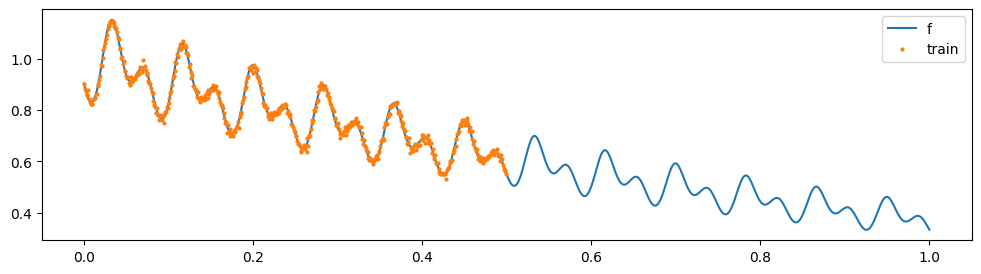

In [3]:
N = 1000
x = torch.linspace(0, 1, N).reshape(-1, 1)
f = lambda x: torch.exp(-(torch.sin(48 * np.pi * x) + torch.cos(24 * np.pi * x) + 10*x)/10)
# f = lambda x: x ** 2 
# f = lambda x: torch.log(x)
# a non-smooth degree 5 polynomial function
# f = lambda x: 0.01 * x ** 5 - 0.2 * x ** 3 - x + 0.5

x_train = x[:N//2]
noise_std = 0.01
y_train = f(x_train) + noise_std * torch.randn(N//2, 1)

plt.figure(figsize=(12, 3))
plt.plot(x.cpu(), f(x).cpu(), label='f');
plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
plt.legend();

In [4]:
lookback_window = 128*2
lookahead_window = 128
x_in = []
x_out = []
y_in = []
y_out = []
for i in range(lookback_window, len(x_train)-lookahead_window+1):
    x_in.append(x_train[i-lookback_window:i][np.newaxis, ...])
    x_out.append(x_train[i:i+lookahead_window][np.newaxis, ...])
    y_in.append(y_train[i-lookback_window:i][np.newaxis, ...])
    y_out.append(y_train[i:i+lookahead_window][np.newaxis, ...])

x_in = torch.cat(x_in, dim=0)
x_out = torch.cat(x_out, dim=0)
y_in = torch.cat(y_in, dim=0)
y_out = torch.cat(y_out, dim=0)
print(x_in.shape, x_out.shape, y_in.shape, y_out.shape)

torch.Size([117, 256, 1]) torch.Size([117, 128, 1]) torch.Size([117, 256, 1]) torch.Size([117, 128, 1])


## Training

Loss: 0.0001: 100%|██████████| 500/500 [00:03<00:00, 162.68it/s]


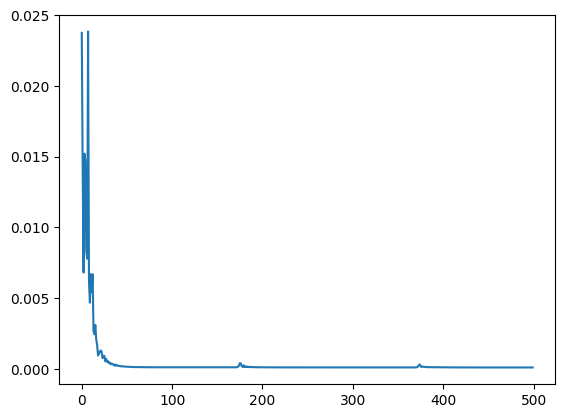

In [5]:
inr = get_initialized_model(1, 16, [256, 256], 30.0, 0.0)
# inr = INR(1, 3, 32, 32, [0.01, 0.1, 1, 5, 10, 20, 50, 100], 0.1)
ridge_reg = RidgeRegressor(lambda_init=0.01)
# print(x.shape, inr(x).shape)

def one_example_forward_pass(x_in, y_in, x_out, mode): # y_in: (lookback_window, 1)
    if mode == "train":
        inr.train()
        ridge_reg.train()
    else:
        inr.eval()
        ridge_reg.eval()
        
    t = torch.linspace(0, 1, lookback_window+lookahead_window).reshape(-1, 1)
    time_repr = inr(t)
    lookback_repr = time_repr[:lookback_window]
    lookahead_repr = time_repr[-lookahead_window:]
    # lookback_repr = inr(x_in)
    # lookahead_repr = inr(x_out)
    
    # w, b = get_lr_weights(lookback_repr, y_in, noise_std**2)
    w, b = ridge_reg(lookback_repr[np.newaxis, ...], y_in[np.newaxis, ...])
    y_pred = torch.matmul(lookahead_repr, w[0]) + b[0]
    
    return y_pred
forward_pass = torch.vmap(one_example_forward_pass, in_dims=(0, 0, 0, None), out_dims=0, randomness="different")

optimizer = torch.optim.Adam([*inr.parameters(), 
                              *ridge_reg.parameters()
                              ], lr=1e-3)
epochs = 500

pbar = tqdm(range(epochs))
losses = []

# train_loader = DataLoader(TensorDataset(x_in, y_in, x_out, y_out), batch_size=1, shuffle=True)

for i in pbar:
    # epoch_loss = 0.0
    # for x_in, y_in, x_out, y_out in train_loader:
    optimizer.zero_grad()
    y_pred = forward_pass(x_in, y_in, x_out, "train")
    # print(y_pred.shape, y_out.shape)
    loss = F.mse_loss(y_pred.ravel(), y_out.ravel())
    loss.backward()
    optimizer.step()
    pbar.set_description(f'Loss: {loss.item():.4f}')
    # losses.append(loss.item())
    # epoch_loss += loss.item()
    # losses.append(epoch_loss / len(train_loader))
    losses.append(loss.item())
    
plt.plot(losses)

## Testing

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


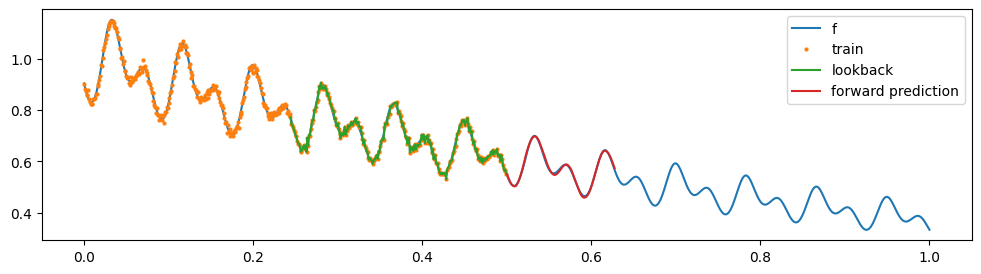

In [6]:
print(x_train.shape, y_train.shape, x.shape)
with torch.no_grad():
    x_test = x[N//2:N//2+lookahead_window]
    y_pred = one_example_forward_pass(x_train[-lookback_window:], y_train[-lookback_window:], x_test, "test")
    print(y_pred.shape)

plt.figure(figsize=(12, 3))
plt.plot(x.cpu(), f(x).cpu(), label='f');
plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
plt.plot(x_train[-lookback_window:].cpu(), y_train[-lookback_window:].cpu(), label='lookback');
plt.plot(x_test.cpu(), y_pred.cpu(), label='forward prediction');
plt.legend();

In [7]:
# print(x_train.shape, y_train.shape, x.shape)
# lookback_window = N//2
# lookahead_window = N//2
# with torch.no_grad():
#     # x_test = x[N//2:N//2+new_lookahead_window]
#     y_pred = one_example_forward_pass(x_train[-lookback_window:], y_train[-lookback_window:], x[N//2:], "test")
#     print(y_pred.shape)

# plt.figure(figsize=(12, 3))
# plt.plot(x.cpu(), f(x).cpu(), label='f');
# plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
# plt.plot(x[N//2:].cpu(), y_pred.cpu(), label='pred');
# plt.legend();

In [8]:
F.softplus(ridge_reg._lambda)

tensor(0.7038, device='cuda:0', grad_fn=<SoftplusBackward0>)

## Their code

## Appendix

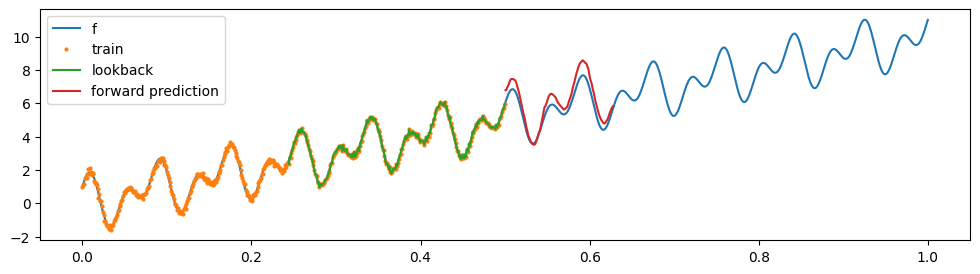

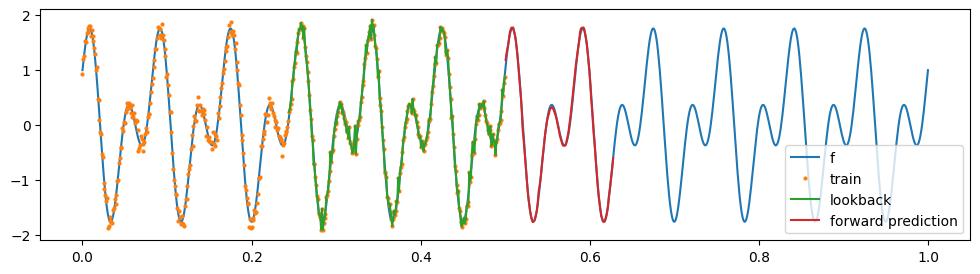

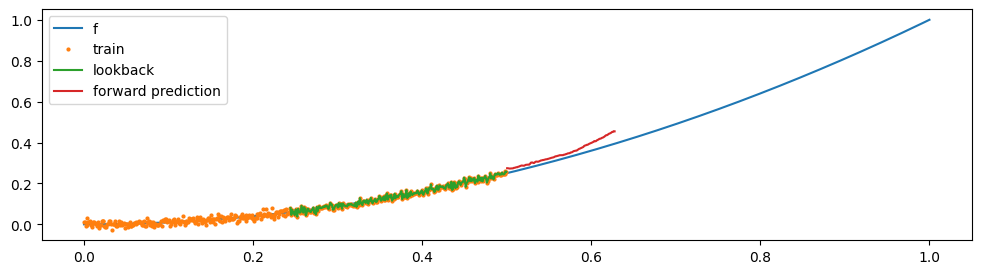

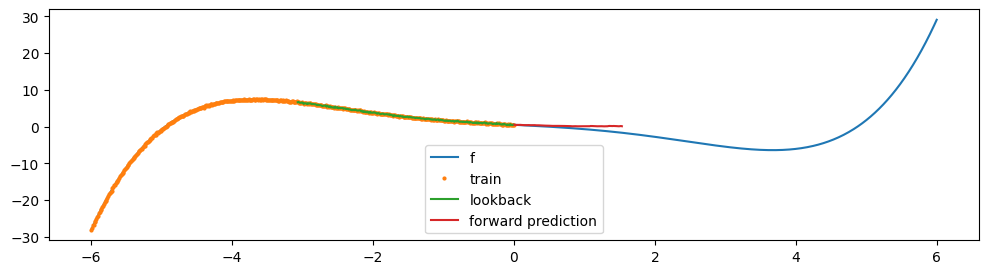